In [ ]:
a=2
a

In [3]:

import sys
sys.path.append("../metakpick/")

import _utils_tree, _utils_kraken,_classifier, _utils, _training
# from _utils  import get_features_read
# from _utils  import get_features_read
import importlib 
importlib.reload(_utils_tree)
importlib.reload(_utils_kraken)
importlib.reload(_classifier)
importlib.reload(_classifier)
importlib.reload(_utils)
importlib.reload(_training)


<module '_training' from '/vast/blangme2/smajidi5/metagenomics/metakpick_project/MetaKPick/utils_notebook/../metakpick/_training.py'>

In [4]:

import os
wdir="/vast/blangme2/smajidi5/metagenomics/metakpick_project/"
tree_file=wdir+"/files/nodes.dmp"
tax_genome_file=wdir+"/files/seqid2taxid.map_tax_uniq"
info, Tree, tax_index, tax_genome, parents, tree_df = _utils_tree.get_tax_info(tree_file,tax_genome_file)    


In [5]:
dataset_folder='cami_plant_short0_20k' # cami_plant_short0_20k cami_plant_long0_20k  cami_marine_short0_20k 
kraken_output_folder=wdir+"changek/kraken1/"+dataset_folder+"/" 
truth_file=kraken_output_folder+"true_tax.csv"
dic_tax_truth = _utils_kraken.read_truth_file(truth_file)
len(dic_tax_truth)

20000

In [6]:
print("Number of reads in the truth file: "+str(len(dic_tax_truth)))
cases=[i.split("_")[0] for i in os.listdir(kraken_output_folder) if i.endswith('_out')]
print("List of kraken indexes  aka cases: "+str(cases))
#cases=[case for case in cases if int(case[1:]) in kmer_list] #'k19'
#print("List of kraken indexes  intersected with the input kmer list: "+str(cases))
read_names_list, kraken_kmers_cases = _utils_kraken.read_kraken_all(cases, kraken_output_folder)
print(len(read_names_list))

Number of reads in the truth file: 20000
List of kraken indexes  aka cases: ['k17', 'k19', 'k21', 'k23', 'k25', 'k27', 'k29', 'k31']
20000


In [7]:
read_name_set=set(read_names_list)
reads_tp_cases_all={}
for tax_level in ['species','genus','family','order','class']:
    reads_tp_cases_all[tax_level] = _utils_kraken.calculate_true_k(kraken_kmers_cases,dic_tax_truth,info,tree_df,parents,tax_level,tax_index,read_names_list)


kraken_reportedtax_cases={}
for case in cases:
    kraken_reportedtax_cases[case]={}
    for read_name in read_names_list:
        kraken_info=kraken_kmers_cases[case][read_name]
        reported_tax = kraken_info[0]
        kraken_reportedtax_cases[case][read_name]=reported_tax

print(kraken_reportedtax_cases.keys())

kraken_reportedtax_cases[ "Oracle"]={}
for tax_level in ['species','genus','family','order','class']:
    kraken_reportedtax_cases[ "Oracle"][tax_level]={}
    for read_name in read_names_list:
        true_k_set= reads_tp_cases_all[tax_level][read_name]
        found_true_tax= 0
        if true_k_set:
            case_true_k = 'k'+str(list(true_k_set)[0])
            found_true_tax = kraken_reportedtax_cases[case_true_k][read_name]
        kraken_reportedtax_cases[ "Oracle"][tax_level][read_name] = found_true_tax 


dict_keys(['k17', 'k19', 'k21', 'k23', 'k25', 'k27', 'k29', 'k31'])


In [8]:
import random
kraken_reportedtax_cases["Random"]={} 
for read_name in read_names_list:
    case_random = cases[random.randint(0, len(cases)-1)]
    kraken_reportedtax_cases["Random"][read_name]  = kraken_reportedtax_cases[case_random][read_name]      	     

print("Calculating the tp fp")
stats={}
print("case\tF1\tprecision\trecall\tTP\tFP\tVP")
for level in ['species','genus']: #,'genus','family','order','class' species genus
    stats[level]={}
    #print("level: "+level)
    stats_fp=[]
    stats_tp=[]
    stats_vp=[]
    precision_list=[]
    recall_list=[]
    F1_list=[]
    for case in list(cases)+["Random","Oracle" ]: # ,"RF" +
        #print("Calculating the tp fp for case: "+case+" level: "+level)
        if case=='Oracle':
            read_tpfp_dic = _utils_kraken.calculate_tp_fp('predicted_tax',kraken_reportedtax_cases[case][level],dic_tax_truth,info,tree_df,parents,level,tax_index,read_name_set)            
        else:
            read_tpfp_dic = _utils_kraken.calculate_tp_fp('predicted_tax',kraken_reportedtax_cases[case],dic_tax_truth,info,tree_df,parents,level,tax_index,read_name_set)
    
            #print("Number of reads in the TP: "+str(len(read_tpfp_dic['TP'])) + " case: "+case+ " level: "+level)

        FP=len(read_tpfp_dic['FP-level-index'])+len(read_tpfp_dic['FP-higher-index'])+len(read_tpfp_dic['FP-level-notindex'])+len(read_tpfp_dic['FP-higher-notindex'])
        denominator=(len(read_tpfp_dic['TP']) + len(read_tpfp_dic['VP']) + len(read_tpfp_dic['FN']) +FP )
        if denominator>0:
            recall=len(read_tpfp_dic['TP'])/denominator
        else:
            recall=0
        if len(read_tpfp_dic['TP'])!=0:
            precision=len(read_tpfp_dic['TP'])/(len(read_tpfp_dic['TP']) + FP)
            F1= 2* precision* recall/(precision+recall)
        else:
            precision=0
            F1=0
        if case=='Oracle':
            stats[level]['oracle']=(precision,recall,F1) # (precision,recall,F1)
        elif case=='Random':
            stats[level]['random']=(precision,recall,F1)
        else:
            stats_fp.append(FP)
            stats_tp.append(len(read_tpfp_dic['TP']))
            stats_vp.append(len(read_tpfp_dic['VP']))
            precision_list.append(precision)
            recall_list.append(recall)
            F1_list.append(F1)
        #print('=='+level+'_'+case+','+str(round(F1,4))+","+str(round(precision,4))+","+str(round(recall,4))+","+str(len(read_tpfp_dic['TP']))+","+str(FP)+","+str(len(read_tpfp_dic['VP'])))
    stats[level].update({'fp':stats_fp,'tp':stats_tp,'vp':stats_vp,'precision':precision_list,'recall':recall_list,'F1':F1_list})
print('done')

# for i in range(len(stats_fp)):
#     print(cases[i],stats_fp[i]+stats_tp[i]+stats_vp[i])

Calculating the tp fp
case	F1	precision	recall	TP	FP	VP
done


In [9]:
import pandas as pd
import numpy as np
cases_int= [int(i.split('k')[1]) for i in cases]
level='species'
dataframe=pd.DataFrame(np.array([[level]*len(cases),cases_int, stats[level]['tp'],stats[level]['fp'],stats[level]['vp'], np.round(stats[level]['precision'],4),np.round(stats[level]['recall'],4),np.round(stats[level]['F1'],4)]).T, 
columns=['level', 'cases', 'tp', 'fp', 'vp','precision','recall','F1'])
level='genus'
dataframe2=pd.DataFrame(np.array([[level]*len(cases),cases_int, stats[level]['tp'],stats[level]['fp'],stats[level]['vp'], np.round(stats[level]['precision'],4),np.round(stats[level]['recall'],4),np.round(stats[level]['F1'],4)]).T, 
columns=['level', 'cases', 'tp', 'fp', 'vp','precision','recall','F1'])
dataframe=pd.concat([dataframe,dataframe2],axis=0)
dataframe['cases']=dataframe['cases'].astype(int)
dataframe['tp']=dataframe['tp'].astype(int)
dataframe['fp']=dataframe['fp'].astype(int)
dataframe['vp']=dataframe['vp'].astype(int)
dataframe['precision']=dataframe['precision'].astype(float)
dataframe['recall']=dataframe['recall'].astype(float)
dataframe['F1']=dataframe['F1'].astype(float)
#dataframe.to_csv('figures/Nov17_'+dataset_folder+'_tp_fp_vp_F1_precision_recall.csv',index=False)

dataframe

,level,cases,tp,fp,vp,precision,recall,F1
0,species,17,768,5876,6922,0.1156,0.0566,0.0760
1,species,19,2735,7342,3489,0.2714,0.2016,0.2314
2,species,21,3215,7231,2993,0.3078,0.2391,0.2691
3,species,23,3327,6039,2835,0.3552,0.2700,0.3068
4,species,25,3336,5229,2840,0.3895,0.2861,0.3299
5,species,27,3320,4784,2912,0.4097,0.2925,0.3413
6,species,29,3296,4556,2873,0.4198,0.2965,0.3475
7,species,31,3253,4299,2866,0.4307,0.2987,0.3528
0,genus,17,4591,5894,7123,0.4379,0.2607,0.3268
1,genus,19,13252,3103,1253,0.8103,0.7526,0.7804


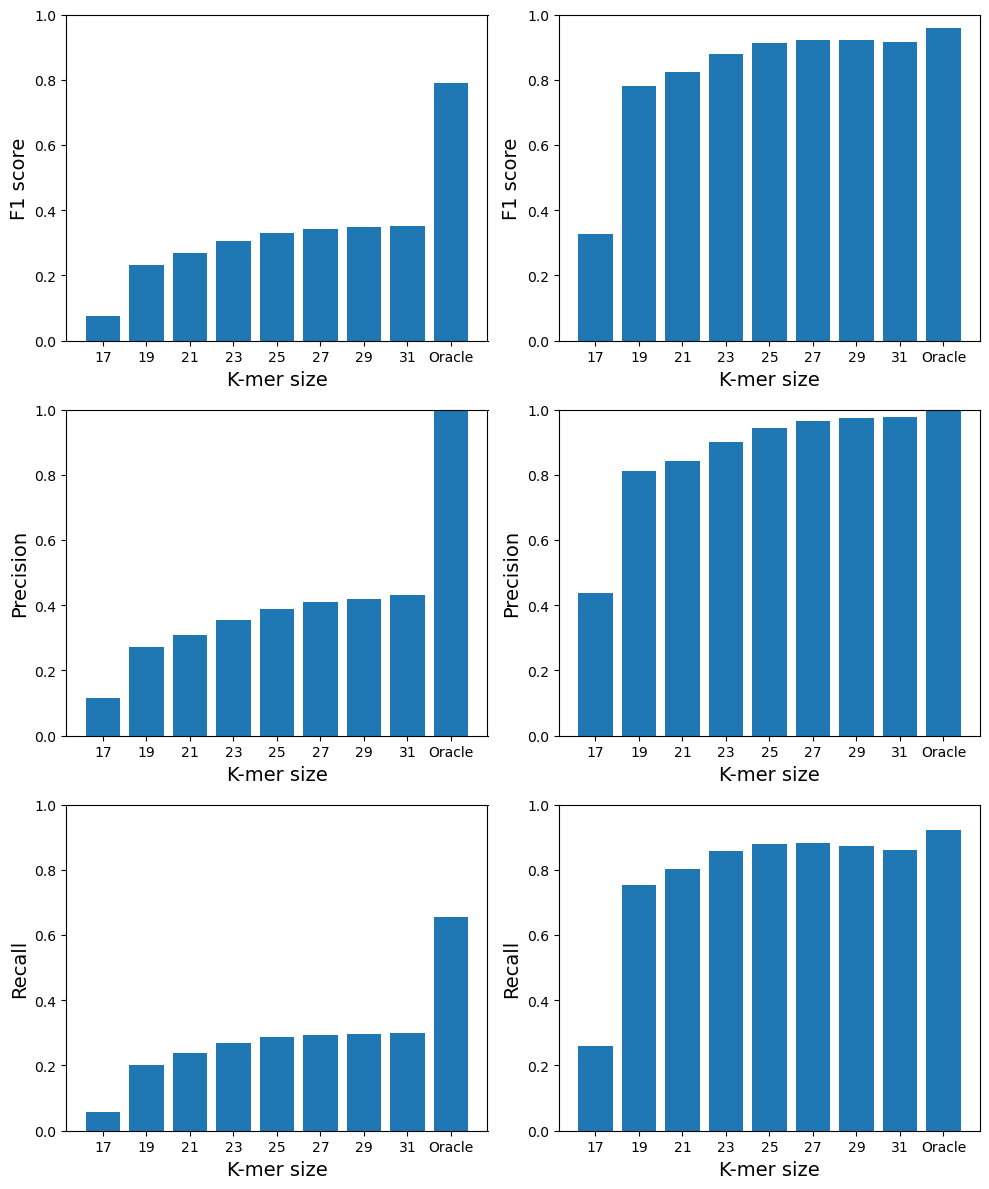

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12),dpi=100)


level='species'
F1=list(dataframe[dataframe['level']==level]['F1'])+[stats[level]['oracle'][2]]
precision=list(dataframe[dataframe['level']==level]['precision'])+[stats[level]['oracle'][0]]
recall=list(dataframe[dataframe['level']==level]['recall'])+[stats[level]['oracle'][1]]
axes[0,0].bar(range(len(F1)),F1)
axes[0,0].set_xlabel('K-mer size', fontsize=14)
axes[0,0].set_ylabel('F1 score', fontsize=14)
axes[0,0].set_xticks(range(len(F1)), cases_int + ['Oracle'])#  fontsize=14
axes[0,0].set_ylim(0,1)

axes[1,0].bar(range(len(F1)),precision)
axes[1,0].set_xlabel('K-mer size', fontsize=14)
axes[1,0].set_ylabel('Precision', fontsize=14)
axes[1,0].set_xticks(range(len(F1)), cases_int + ['Oracle'])#  fontsize=14
axes[1,0].set_ylim(0,1)


axes[2,0].bar(range(len(F1)),recall)
axes[2,0].set_xlabel('K-mer size', fontsize=14)
axes[2,0].set_ylabel('Recall', fontsize=14)
axes[2,0].set_xticks(range(len(F1)), cases_int + ['Oracle'])#  fontsize=14
axes[2,0].set_ylim(0,1)


level='genus'
F1=list(dataframe[dataframe['level']==level]['F1'])+[stats[level]['oracle'][2]]
precision=list(dataframe[dataframe['level']==level]['precision'])+[stats[level]['oracle'][0]]
recall=list(dataframe[dataframe['level']==level]['recall'])+[stats[level]['oracle'][1]]
axes[0,1].bar(range(len(F1)),F1)
axes[0,1].set_xlabel('K-mer size', fontsize=14)
axes[0,1].set_ylabel('F1 score', fontsize=14)
axes[0,1].set_xticks(range(len(F1)), cases_int + ['Oracle'])#  fontsize=14
axes[0,1].set_ylim(0,1)

axes[1,1].bar(range(len(F1)),precision)
axes[1,1].set_xlabel('K-mer size', fontsize=14)
axes[1,1].set_ylabel('Precision', fontsize=14)
axes[1,1].set_xticks(range(len(F1)), cases_int + ['Oracle'])#  fontsize=14
axes[1,1].set_ylim(0,1)


axes[2,1].bar(range(len(F1)),recall)
axes[2,1].set_xlabel('K-mer size', fontsize=14)
axes[2,1].set_ylabel('Recall', fontsize=14)
axes[2,1].set_xticks(range(len(F1)), cases_int + ['Oracle'])#  fontsize=14
axes[2,1].set_ylim(0,1)
plt.tight_layout()
plt.savefig('figures/Nov17_'+dataset_folder+'_F1_precision_recall_oracle.png',dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
#dataset_folder='cami_plant_long0_20k'
short_long=dataset_folder.split('_')[2][:-1]
plant_marine =dataset_folder.split('_')[1]
dataset='CAMI '+plant_marine+' '+short_long+' read'


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12),dpi=300)

level='species'
cases_int=list(dataframe[dataframe['level']==level]['cases'])
tp=list(dataframe[dataframe['level']==level]['tp'])
fp=list(dataframe[dataframe['level']==level]['fp'])
vp=list(dataframe[dataframe['level']==level]['vp'])
precision=list(dataframe[dataframe['level']==level]['precision'])
recall=list(dataframe[dataframe['level']==level]['recall'])
F1=list(dataframe[dataframe['level']==level]['F1'])
axes[0,0].plot(cases_int,precision,label='Precision',color='blue',marker='o')
axes[0,0].plot(cases_int,recall,label='Recall',color='orange',marker='o')
axes[0,0].plot(cases_int,F1,label='F1',color='green',marker='o')
axes[0,0].legend(fontsize=14)
axes[0,0].set_xlabel('K-mer size',fontsize=14)
axes[0,0].set_ylabel('Metric',fontsize=14)
axes[0,0].set_title(dataset+' at '+level+' level')
axes[0,0].set_xticks(cases_int, [str(i) for i in cases_int])
axes[0,0].set_ylim(0,1)

axes[0,1].plot(cases_int,tp,label='True Positive',color='green',marker='o')
axes[0,1].plot(cases_int,vp,label='Vague Positive',color='olive',marker='o')
axes[0,1].plot(cases_int,fp,label='False Positive',color='red',marker='o')
axes[0,1].legend(fontsize=14)
axes[0,1].set_xlabel('K-mer size',fontsize=14)
axes[0,1].set_ylabel('Number of reads',fontsize=14)
axes[0,1].set_title(dataset+' at '+level+' level')
axes[0,1].set_xticks(cases_int, [str(i) for i in cases_int])
axes[0,1].set_ylim(0,18000)

level='genus'
cases=list(dataframe[dataframe['level']==level]['cases'])
tp=list(dataframe[dataframe['level']==level]['tp'])
fp=list(dataframe[dataframe['level']==level]['fp'])
vp=list(dataframe[dataframe['level']==level]['vp'])
precision=list(dataframe[dataframe['level']==level]['precision'])
recall=list(dataframe[dataframe['level']==level]['recall'])
F1=list(dataframe[dataframe['level']==level]['F1'])
axes[1,0].plot(cases_int,precision,label='Precision',color='blue',marker='o')
axes[1,0].plot(cases_int,recall,label='Recall',color='orange',marker='o')
axes[1,0].plot(cases_int,F1,label='F1',color='green',marker='o')
axes[1,0].legend(fontsize=14)
axes[1,0].set_xlabel('K-mer size',fontsize=14)
axes[1,0].set_ylabel('Metric',fontsize=14)
axes[1,0].set_title(dataset+' at '+level+' level')
axes[1,0].set_xticks(cases_int, [str(i) for i in cases_int])
axes[1,0].set_ylim(0,1)


axes[1,1].plot(cases_int,tp,label='True Positive',color='green',marker='o')
axes[1,1].plot(cases_int,vp,label='Vague Positive',color='olive',marker='o')
axes[1,1].plot(cases_int,fp,label='False Positive',color='red',marker='o')
axes[1,1].legend(fontsize=14)
axes[1,1].set_xlabel('K-mer size',fontsize=14)
axes[1,1].set_ylabel('Number of reads',fontsize=14)
axes[1,1].set_title(dataset+' at '+level+' level')
axes[1,1].set_xticks(cases_int, [str(i) for i in cases_int])
axes[1,1].set_ylim(0,18000)

plt.savefig('figures/Nov17_'+dataset+'_c.png',dpi=300)
plt.tight_layout()
plt.show()


In [ ]:
#for level in ['species','genus']: #,'genus','family','order','class' species genus
level='species'
#print("level: "+level)

read_tpfp_dic_all={}
for case in list(cases): # ,"RF" +["Random","Oracle" ]
    case_k='k'+str(case)
    read_tpfp_dic = _utils_kraken.calculate_tp_fp('predicted_tax',kraken_reportedtax_cases[case_k],dic_tax_truth,info,tree_df,parents,level,tax_index,read_name_set)
    read_tpfp_dic_all[case_k]=read_tpfp_dic


In [ ]:
kraken_reportedtax_cases.keys()
#len(kraken_reportedtax_cases[case])

In [ ]:
#read_tpfp_dic.keys()


In [ ]:
matrix_true= np.zeros([len(read_names_list),len(cases)])
for read_idx, read in enumerate(read_names_list):
    for i,case in enumerate(cases):
        case_k='k'+str(case)
        if read in read_tpfp_dic_all[case_k]['TP']:
            matrix_true[read_idx,i]=1
        elif read in read_tpfp_dic_all[case_k]['VP']:
            matrix_true[read_idx,i]=2
        elif read in read_tpfp_dic_all[case_k]['FP-level-index'] or read in read_tpfp_dic_all[case_k]['FP-higher-index'] or read in read_tpfp_dic_all[case_k]['FP-level-notindex'] or read in read_tpfp_dic_all[case_k]['FP-higher-notindex']:
            matrix_true[read_idx,i]=3
matrix_true.shape



In [ ]:
# filter row matrix
matrix_true_filtered=[]
for i in range(matrix_true.shape[0]):
    if matrix_true[i].sum()!=matrix_true[i,0]*len(cases):
        matrix_true_filtered.append(matrix_true[i])
matrix_true_filtered= np.array(matrix_true_filtered)
print(matrix_true.shape,matrix_true_filtered.shape)




In [ ]:
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
palette = sns.color_palette("tab10")
myColors = (palette[7],palette[2],palette[8],palette[3]) # 0grey, green 1TP, VP2, FP3
#((0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
sns.heatmap(matrix_true_filtered, annot=False, ax=ax,  xticklabels=cases_int, cmap=cmap) #'viridis', norm=LogNorm())#   , norm=plt.colors.LogNorm()  # ,  square=True , linewidths=.5,
# #list(range(15,32))
ax.set_xticks([i+0.5 for i in range(len(cases_int))], [str(i) for i in cases_int])  
ax.set_yticks([])
plt.xlabel('k-mer size', fontsize=14)
plt.ylabel('Reads', fontsize=14)
# plt.title('best_score | score= No. k-mer in a path') # /second_best
cbar = ax.collections[0].colorbar
cbar.set_ticks([])
plt.savefig('figures/Nov17_'+dataset+'_matrix_true_filtered.png',dpi=300)
plt.show()

In [ ]:
matrix_not31true= np.zeros([len(read_names_list),len(cases)])
for read_idx, read in enumerate(read_names_list):
    for i,case in enumerate(cases):
        case_k='k'+str(case)
        if read in read_tpfp_dic_all[case_k]['TP'] and read not in read_tpfp_dic_all['k31']['TP']:
            matrix_not31true[read_idx,i]=1
        elif read in read_tpfp_dic_all[case_k]['VP']:
            matrix_not31true[read_idx,i]=2
        
matrix_not31true.shape

# filter row matrix
matrix_not31true_filtered=[]
for i in range(matrix_not31true.shape[0]):
    if (1 in matrix_not31true[i] or 2 in matrix_not31true[i]) and matrix_true[i].sum()!=matrix_true[i,0]*len(cases):
        matrix_not31true_filtered.append(matrix_not31true[i])
matrix_not31true_filtered= np.array(matrix_not31true_filtered)
print(matrix_true.shape,matrix_not31true_filtered.shape)





In [ ]:
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
palette = sns.color_palette("tab10")
myColors = (palette[7],palette[2],palette[8],palette[3]) # 0grey, green 1TP, VP2, FP3
#((0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
sns.heatmap(matrix_not31true_filtered, annot=False, ax=ax,  xticklabels=cases_int, cmap=cmap) #'viridis', norm=LogNorm())#   , norm=plt.colors.LogNorm()  # ,  square=True , linewidths=.5,
# #list(range(15,32))
ax.set_xticks([i+0.5 for i in range(len(cases_int))], [str(i) for i in cases_int])  
ax.set_yticks([])
plt.xlabel('k-mer size', fontsize=14)
plt.ylabel('Reads', fontsize=14)
# plt.title('best_score | score= No. k-mer in a path') # /second_best
cbar = ax.collections[0].colorbar
cbar.set_ticks([])
plt.savefig('figures/Nov17_'+dataset+'_not31.png',dpi=300)
plt.show()

In [ ]:
#matrix_true_filtered[0:4,:]
# 0grey, green 1TP, VP2, FP3
#sns.heatmap(matrix_true_filtered[0:4,:], annot=False, ax=ax,  xticklabels=cases_int, cmap=cmap) #'viridis', norm=LogNorm())#   , norm=plt.colors.LogNorm()  # ,  square=True , linewidths=.5,


In [ ]:
# import matplotlib.pyplot as plt

In [ ]:
# import matplotlib.pyplot as plt

# import matplotlib.pyplot as plt
# dataset='CAMI_Marine_long0'


# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))



# cases_int= [int(i.split('k')[1]) for i in cases]
# plt.plot(cases_int,precision_list,label='Precision',color='blue',marker='o')
# plt.plot(cases_int,recall_list,label='Recall',color='orange',marker='o')
# plt.plot(cases_int,F1_list,label='F1',color='green',marker='o')
# #[i/20000 for i in stats_tp] 
# plt.legend(fontsize=14)
# plt.xlabel('K-mer size',fontsize=14)
# plt.ylabel('Metric',fontsize=14)
# #plt.yscale('log')
# plt.title('CAMI plant-soil at '+level+' level')
# plt.xticks(cases_int, [str(i) for i in cases_int])
# plt.tight_layout()
# #plt.savefig('figures/Nov17_'+dataset+'_'+level+'_F1_precision_recall.png',dpi=300)
# #plt.show()


# cases_int= [int(i.split('k')[1]) for i in cases]
# plt.plot(cases_int,stats_tp,label='True Positive',color='green',marker='o')
# plt.plot(cases_int,stats_fp,label='False Positive',color='red',marker='o')
# plt.plot(cases_int,stats_vp,label='True Negative',color='blue',marker='o')
# #[i/20000 for i in stats_tp] 
# plt.legend(fontsize=14)
# plt.xlabel('K-mer size',fontsize=14)
# plt.ylabel('Number of reads',fontsize=14)
# #plt.yscale('log')
# plt.title('CAMI plant-soil at '+level+' level')
# plt.xticks(cases_int, [str(i) for i in cases_int])
# plt.tight_layout()
# plt.savefig('figures/Nov17_'+dataset+'_'+level+'_tp_fp.png',dpi=300)
# plt.show()


In [ ]:
import matplotlib.pyplot as plt
k=[19,21,23,25,27,29,31]
accs=[0.9349632400922261,0.9434172938327461,0.9535389568016706,0.9633706007743508,0.9703600585838372,0.9746523397282522,0.9775090268412581]

plt.bar(k,accs)
plt.xlabel('K-mer size')
plt.ylabel('Accuracy')
xticks= [str(i) for i in k]
plt.xticks(k, xticks)
plt.show()

#train_max15_80_long1931_80_15sep_topRF_10trees_7Features_10leaves_.log
# 2025-09-17 10:03:14,096 - DEBUG - Accuracy for case k19 is 0.9349632400922261
# 2025-09-17 10:03:43,112 - DEBUG -  Accuracy of the model is 0.9434172938327461
# 2025-09-17 10:03:43,112 - DEBUG - Accuracy for case k21 is 0.9434172938327461
# 2025-09-17 10:04:10,340 - DEBUG -  Accuracy of the model is 0.9535389568016706
# 2025-09-17 10:04:10,340 - DEBUG - Accuracy for case k23 is 0.9535389568016706
# 2025-09-17 10:04:34,452 - DEBUG -  Accuracy of the model is 0.9633706007743508
# 2025-09-17 10:04:34,452 - DEBUG - Accuracy for case k25 is 0.9633706007743508
# 2025-09-17 10:04:55,306 - DEBUG -  Accuracy of the model is 0.9703600585838372
# 2025-09-17 10:04:55,306 - DEBUG - Accuracy for case k27 is 0.9703600585838372
# 2025-09-17 10:05:13,801 - DEBUG -  Accuracy of the model is 0.9746523397282522
# 2025-09-17 10:05:13,801 - DEBUG - Accuracy for case k29 is 0.9746523397282522
# 2025-09-17 10:05:30,841 - DEBUG -  Accuracy of the model is 0.9775090268412581
# 2025-09-17 10:05:30,842 - DEBUG - Accuracy for case k31 is 0.9775090268412581

In [ ]:
import os
folder='../../runs/'
logs= [i for i in os.listdir(folder) if i.endswith('log')]

levels=['species','genus','family','order','class']
len(logs)

In [ ]:
tresholds_treesleaves= [ (10,10,7), (20,20,7), (10,10,11), (20,15,11), (20,20,11)]
cases=['k19','k21','k23','k25','k27','k29','k31','RF','Oracle','Random']

dic_values={}
for level in levels:
    dic_values[level]={}
    for case in cases:
        dic_values[level][case]={}

for (thr1,thr2,thr3) in tresholds_treesleaves:
    #log="classify_sim80_max15_80_long1931_80_15sep_topRF_"+str(thr1)+"trees_"+str(thr3)+"Features_"+str(thr2)+"leaves_topRF.log"
    log="classify_cami_plant_long0_20k_long1931_80_15sep_topRF_"+str(thr1)+"trees_"+str(thr3)+"Features_"+str(thr2)+"leaves_topRF.log"

    with open(folder+log, 'r') as f:
        lines = f.readlines()
    for line in lines:
        #if not line.startswith('2025-09'):
        if line.startswith('=='):
            line_split=line.strip().split(',')[0].split('_')
            
            if line_split[0][2:] in levels:
                case=line_split[1]
                level=line_split[0][2:]
                F1=float(line.split(',')[1])
                precision=float(line.split(',')[2])
                recall=float(line.split(',')[3])
                TP=int(line.split(',')[4])
                FP=int(line.split(',')[5])
                VP=int(line.split(',')[6].strip())
                dic_values[level][case.strip()][(thr1,thr2,thr3)]={'F1':F1,'precision':precision,'recall':recall,'TP':TP,'FP':FP,'VP':VP}
                #print(level,F1,precision,recall,TP,FP,VP)

import numpy as np
level='genus' #'species' genus genus
case='RF'
thrs =[]
F1s=[]
for (thr1,thr2,thr3), dic_val in dic_values[level][case].items():
    thrs.append(str(thr1)+'_'+str(thr2)+'_'+str(thr3))
    F1s.append(dic_val['F1'])
    #print(thr1,thr2,dic_val['F1'])
        
np.mean(F1s)

cases_k= [i for i in cases if i.startswith('k')]
cases_k
F1_cases=[]
for case in cases_k:
    F1_cases.append(dic_values[level][case][(thr1,thr2,thr3)]['F1'])
F1_max= max(F1_cases)
case_k_max = cases_k[np.argmax(F1_cases)]
F1_max,case_k_max


In [ ]:
import matplotlib.pyplot as plt
figure=plt.figure()
plt.bar(thrs,F1s)
plt.title(level)
plt.xlabel('Trees_leaves_features')
plt.ylabel('F1 Score')
plt.xticks(thrs, rotation=90)
plt.tight_layout()
plt.axhline(y=F1_max, color='red', linestyle='--')
plt.text(2, 0.999*F1_max ,'max per k:'+case_k_max, ha='center', va='bottom',color='red') # 1.01
#plt.ylim(0.795,0.815)
plt.ylim(0.895,0.915)
plt.show()

In [ ]:
pwd

# generate figure decision 

In [ ]:
import os
folder='../../runs/' # decision3_thresholds
logs= [i for i in os.listdir(folder) if i.endswith('log') if 'decision3' in i and 'from_input' not in i] # 

levels=['species','genus','family','order','class']
len(logs)

cases=['k19','k21','k23','k25','k27','k29','k31','RF','Oracle','Random']
log=logs[0]
dic_values={}
for level in levels:
    dic_values[level]={}
    for case in cases:
        dic_values[level][case]={}

log=logs[0]

[float(i) for i in log.split('decision3')[1].split('.log')[0].split('_') if i]
logs

In [ ]:
for log in logs:
    thr1,thr2 = [float(i) for i in log.split('decision3')[1].split('.log')[0].split('_') if i] # 'classify_cami_max15_80_long1931_80_6sep_npath__decision3_0.2_0.1_2.log'

    with open(folder+log, 'r') as f:
        lines = f.readlines()
    for line in lines:
        #if not line.startswith('2025-09'):
        if line.startswith('=='):
            line_split=line.strip().split(',')[0].split('_')
            
            if line_split[0][2:] in levels:
                case=line_split[1]
                level=line_split[0][2:]
                F1=float(line.split(',')[1])
                precision=float(line.split(',')[2])
                recall=float(line.split(',')[3])
                TP=int(line.split(',')[4])
                FP=int(line.split(',')[5])
                VP=int(line.split(',')[6].strip())
                dic_values[level][case.strip()][(thr1,thr2)]={'F1':F1,'precision':precision,'recall':recall,'TP':TP,'FP':FP,'VP':VP}
                #print(level,F1,precision,recall,TP,FP,VP)

import numpy as np
level='genus' #'species' genus
case='RF'
thrs =[]
F1s=[]
for (thr1,thr2), dic_val in dic_values[level][case].items():
    thrs.append(str(thr1)+'_'+str(thr2))
    F1s.append(dic_val['F1'])
    #print(thr1,thr2,dic_val['F1'])
        
np.mean(F1s)

cases_k= [i for i in cases if i.startswith('k')]
cases_k
F1_cases=[]
for case in cases_k:
    F1_cases.append(dic_values[level][case][(thr1,thr2)]['F1'])
F1_max= max(F1_cases)
case_k_max = cases_k[np.argmax(F1_cases)]
F1_max,case_k_max

In [ ]:
import matplotlib.pyplot as plt
figure=plt.figure()
plt.bar(thrs,F1s)
plt.title(level)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.xticks(thrs, rotation=90)
plt.tight_layout()
plt.axhline(y=F1_max, color='red', linestyle='--')
#plt.text(23, 0.995*F1_max ,'max per k:'+case_k_max, ha='center', va='bottom',color='red') # 1.01
#plt.ylim(0.9,0.99)
#plt.ylim(0.81,0.89)
plt.show()

In [ ]:
max(F1s),thrs[np.argmax(F1s)]

In [ ]:

# level='species'
# tresholds= set(dic_values.keys())
# cases=['k19','k21','k23','k25','k27','k29','k31','RF','Oracle','Random']
# tresholds_case= level+'_'+case
# F1_values=[dic_values[i][]['F1'] for i in tresholds]




In [ ]:
dic_values[(thr1,thr2)][level]